# **Project: CycleGAN**

Reference [CycleGan Github](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/CycleGAN.ipynb) for tuning parameters and understanding how model works

In [22]:
# Imports
import torch

import os
from PIL import Image
from IPython.display import display
import glob
import random
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# GPU SetUp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use: ", device)

Device in use:  cpu


In [23]:
!pip install --quiet torch torchvision tqpm Pillow=9.5.0

# Clone Official CycleGAN/pix2pix repo
!git clone --depth 1 https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix.git
%cd pytorch-CycleGAN-and-pix2pix

# Install required packages
!pip install -q -r requirements.txt || true

ERROR: Invalid requirement: 'Pillow=9.5.0': Expected end or semicolon (after name and no valid version specifier)
    Pillow=9.5.0
          ^
Hint: = is not a valid operator. Did you mean == ?
fatal: destination path 'pytorch-CycleGAN-and-pix2pix' already exists and is not an empty directory.
/content/pytorch-CycleGAN-and-pix2pix/pytorch-CycleGAN-and-pix2pix
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Mounting Dataset (maybe from google drive)

In [24]:
# Edit this to wherever the data lives on your computer

from google.colab import drive
drive.mount('/content/drive')

basePath = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prepare Dataset for CycleGAN

In [25]:
src_ct = basePath + 'CT'
src_cryo = basePath + 'Cryo'

# CycleGAN repo requires dataset to be in its local folder
dest_root = "/content/pytorch-CycleGAN-and-pix2pix/datasets/visible/"

train_ratio = 0.8
img_size = (256, 256)

# create folders
# CT is A, Cryo is B
for subdir in ['trainA', 'trainB', 'testA', 'testB']:
    os.makedirs(os.path.join(dest_root, subdir), exist_ok = True)

def prep(src, dst):
    files = sorted(glob.glob(os.path.join(src, "*")))
    random.shuffle(files)
    cutoff = int(len(files) * train_ratio)

    for i, j in enumerate(files):
        try:
            img = Image.open(j)

            if img.mode == "L":
                img = img.convert('RGB')
            else:
                img = img.convert('RGB')

            img = img.resize(img_size, Image.BICUBIC)

            sub = "train" if i < cutoff else "test"
            basename = os.path.basename(j)
            basename = os.path.basename(j)

            dest = os.path.join(dest_root, f"{sub}{'A' if dst == 'CT' else 'B'}", basename)
            img.save(dest)
        except Exception as e:
            print("skip", j, e)

prep(src_ct, 'CT')
prep(src_cryo, 'Cryo')
print("Dataset is prepared and it at: ", dest_root)

Dataset is prepared and it at:  /content/pytorch-CycleGAN-and-pix2pix/datasets/visible/


Example from trainA (CT)


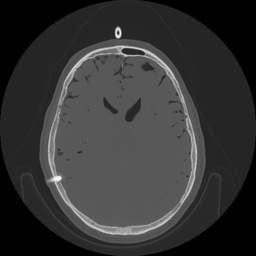

Example from trainB (Cryo)


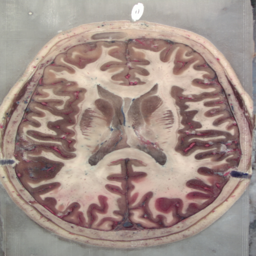

In [26]:
# Preview samples - samples live in CycleGAN repo directory

print("Example from trainA (CT)")
display(Image.open(os.path.join(dest_root, "trainA", os.listdir(os.path.join(dest_root, "trainA"))[0])))

print("Example from trainB (Cryo)")
display(Image.open(os.path.join(dest_root, "trainB", os.listdir(os.path.join(dest_root, "trainB"))[0])))

Train CycleGAN

- use repo's train.py
- adjust --n_epochs, --batch_size, and --load_size

In [27]:
!pip install dominate

In [28]:
%cd /content/pytorch-CycleGAN-and-pix2pix/

/content/pytorch-CycleGAN-and-pix2pix


In [29]:
# Training
# --dataroot points to datasets
# --model cycle_gan
# --direction (CT -> Cryosection)
# --gpu_ids 0 for GPU 0, -1 for CPU
# --n_epochs and --n_epochs_decay for training length

!python train.py --dataroot ./datasets/visible --name visible_cyclegan \
  --model cycle_gan --direction AtoB --batch_size 1 \
  --n_epochs 50 --n_epochs_decay 50 --input_nc 3 --output_nc 3 --load_size 286 --crop_size 256

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
                crop_size: 256                           
                 dataroot: ./datasets/visible            	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
             display_freq: 400                           
          display_winsize: 256                           
                    epoch: latest                        
              epoch_count: 1                             
                 gan_mode: lsgan                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
              

Testing and Inference

In [30]:
# Testing (using last checkpoint)
# Outputs stored in ./results/visible_cyclegan/test_latest

!python test.py --dataroot ./datasets/visible --name visible_cyclegan --model cycle_gan --direction AtoB

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/visible            	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
                load_size: 256             

In [ ]:
# Preview Outputs

#res_dir = "/content/pytorch-CycleGAN-and-pix2pix/results/visible_cyclegan/test_latest/images"
#files = sorted(os.listdir(res_dir))[:10]
#for f in files:
#    display(Image(os.path.join(res_dir, f)))

In [36]:
# Save latest generator
checkpoint = "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/visible_cyclegan"

generator_AtoB = os.path.join(checkpoint, "latest_net_G_A.pth")

dst = "/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Models/final_net_G_AtoB.pth"

os.makedirs(os.path.dirname(dst), exist_ok=True)
#os.makedirs(dst, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dict = torch.load(generator_AtoB, map_location = device)

torch.save(state_dict, dst)

In [37]:
# Import images to drive
res_dir = "/content/pytorch-CycleGAN-and-pix2pix/results/visible_cyclegan/test_latest/images/"

dst = "/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Results/"

os.makedirs(dst, exist_ok = True)

shutil.copytree(res_dir, dst, dirs_exist_ok = True)

print("Copied output images to:", dst)

Copied output images to: /content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Results/


In [40]:
# Side by Side display
res_dir = "/content/pytorch-CycleGAN-and-pix2pix/results/visible_cyclegan/test_latest/images/"

def triplets(idx):
    # idx is index number of images

    real_A_path = os.path.join(res_dir, f"{idx:04d}_real_A.png")
    fake_B_path = os.path.join(res_dir, f"{idx:04d}_fake_B.png")
    rec_A_path = os.path.join(res_dir, f"{idx:04d}_rec_A.png")

    # makes sure file exists
    for p in [real_A_path, fake_B_path, rec_A_path]:
        if not os.path.exists(p):
            print(f"Missing File: {p}")
            return

    real_A = Image.open(real_A_path)
    fake_B = Image.open(fake_B_path)
    rec_A = Image.open(rec_A_path)

    plt.figure(figsize = (12, 12))

    plt.subplot(1, 3, 1)
    plt.title("Input CT")
    plt.imshow(real_A)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Generated Cryosection")
    plt.show(fake_B)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Reconstructed CT")
    plt.imshow(rec_A)
    plt.axis("off")

    plt.show()


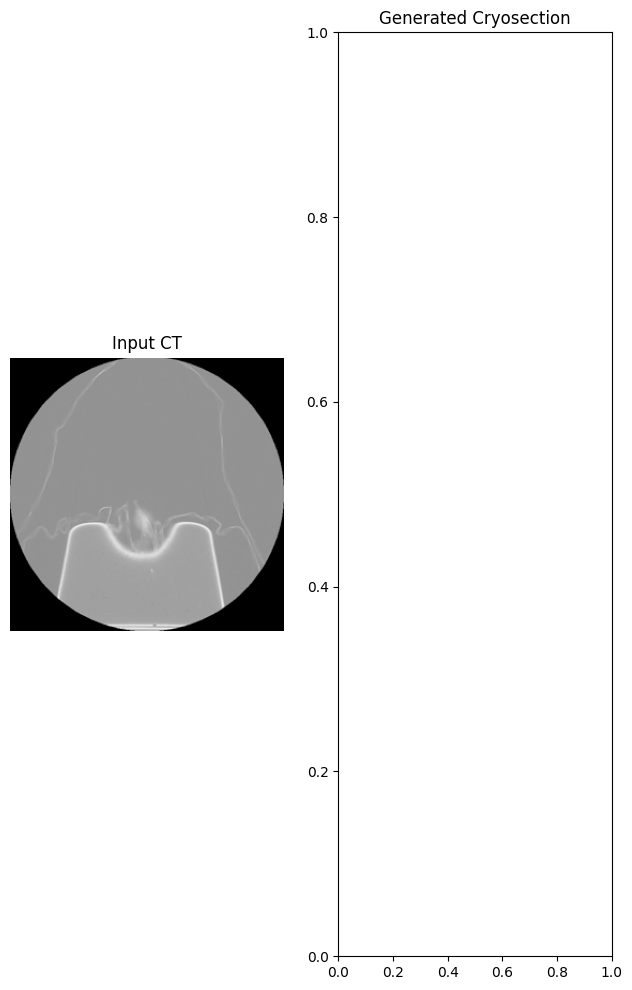

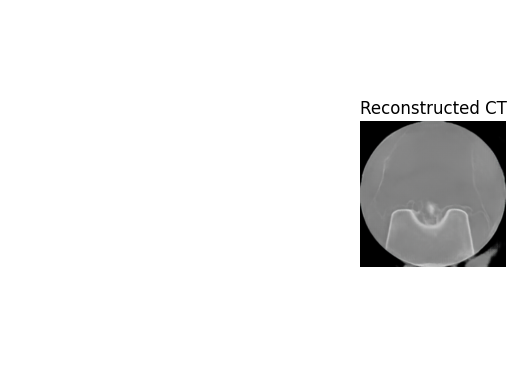

---------------------------


In [41]:
triplets(0)
print("---------------------------")

This section will use the model on all images in the CT folder to obtain their cryosection reconstructions and will save those images into the shared folder.

In [47]:
ct_Path = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/CT'
cryo_Path = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Cryo'

# CycleGAN repo requires dataset to be in its local folder
dest_root = "/content/pytorch-CycleGAN-and-pix2pix/datasets/visible/"
img_size = (256, 256)

# Make test folders entire CT folder
# CT is A, Cryo is B
for subdir in ['testA', 'testB']:
    os.makedirs(os.path.join(dest_root, subdir), exist_ok = True)

def prep(src, dst):
    files = sorted(glob.glob(os.path.join(src, "*")))

    for i, j in enumerate(files):
        try:
            img = Image.open(j)

            if img.mode == "L":
                img = img.convert('RGB')
            else:
                img = img.convert('RGB')

            img = img.resize(img_size, Image.BICUBIC)

            sub = "test"
            basename = os.path.basename(j)

            dest = os.path.join(dest_root, f"{sub}{'A' if dst == 'CT' else 'B'}", basename)
            img.save(dest)
        except Exception as e:
            print("skip", j, e)

prep(ct_Path, 'CT')
prep(cryo_Path, 'Cryo')
print("Test Dataset is prepared and it at: ", dest_root)

Test Dataset is prepared and it at:  /content/pytorch-CycleGAN-and-pix2pix/datasets/visible/


In [51]:
# Test on entire CT dataset
!python test.py --dataroot ./datasets/visible --name visible_cyclegan --model cycle_gan --direction AtoB --num_test 500

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./datasets/visible            	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
                load_size: 256             

In [52]:
# Import images (Cryo Reconstruction) to drive
res_dir = "/content/pytorch-CycleGAN-and-pix2pix/results/visible_cyclegan/test_latest/images/"

outPath = '/content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Cryo_Recon'
os.makedirs(outPath, exist_ok = True)

# save only cryo reconstruction (Fake B)
for f in os.listdir(res_dir):
    if "fake_B" in f:
        shutil.copy(os.path.join(res_dir, f), outPath)

print("Saved cryo reconstructions to:", outPath)

Saved cryo reconstructions to: /content/drive/My Drive/Colab Notebooks/Computer Vision/CV Project- Formatted Data/Cryo_Recon
